In [199]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# Introduction
In this notebook, I’ll be coding my own neural network from scratch for the MNIST dataset. Each data point is a 28×28 image (784 pixels), so our input layer has 784 neurons. Since this is a 10-class classification task (digits 0–9), our output layer will consist of 10 neurons and use a Softmax activation. I’ll include two hidden layers with 10 neurons  using ReLU activation—just because I get good vibes from it.

```python
# Layer definitions
INPUT_SIZE   = 28 * 28    # 784 input neurons (pixels)
HIDDEN_SIZE  = 17         # 17 hidden neurons (ReLU activation)
OUTPUT_SIZE  = 10         # 10 output neurons (Softmax for digits 0–9)

# Activation functions
ACTIVATION_HIDDEN = 'ReLU'
ACTIVATION_OUTPUT = 'Softmax'


# The Data

In [200]:
import matplotlib.pyplot as plt
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [201]:
train = np.array(train)
m , n = train.shape
n = n - 1
np.random.shuffle(train)

In [202]:
X_train = train[:, 1:].T
Y_train = train[:, 0]

Since these are pixel values form 0 to 255, we normalize our data by scaling by 255

In [203]:
X_train = X_train / 255.0

X_train[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Initializing weights and biases.

Now, we must initialize our weights and biases. Since we use the ReLU activation layer, I decided to go with He Initialization

He Initialization is a method of weight initialization using $n_i$ and $n_o$, our input and output neurons, where $n_i = 784$ and $n_o$ = 1. 

The He Intiialization method initializes the weights and biases as a normal distribution function with $\mu = 0$ and $\sigma = \sqrt{\frac{2}{n_1}}$, so in our case, $\sigma = \sqrt{\frac{2}{784}}$. 

In [204]:
import math
def initialize_values():
    W1 = np.random.randn(10, 784) * np.sqrt(2 / 784)  # He initialization for layer 1
    B1 = np.zeros((10, 1))                            # Biases typically initialized to 0
    W2 = np.random.randn(10, 10) * np.sqrt(2 / 10)    # He initialization for layer 2
    B2 = np.zeros((10, 1))
    return W1, B1, W2, B2


## Plotted Example

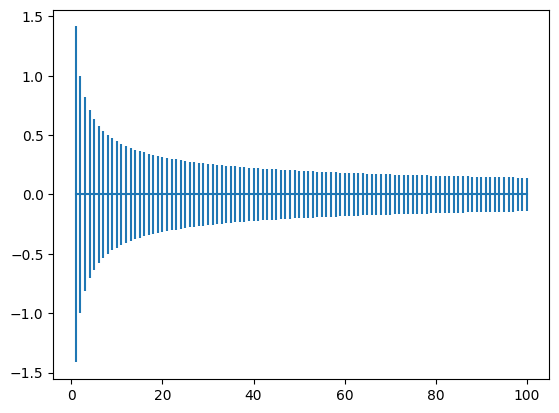

In [205]:
from matplotlib import pyplot
# define the number of inputs from 1 to 100
values = [i for i in range(1, 101)]
# calculate the range for each number of inputs
results = [math.sqrt(2.0 / n) for n in values]
# create an error bar plot centered on 0 for each number of inputs
pyplot.errorbar(values, [0.0 for _ in values], yerr=results)
pyplot.show()

# One hot encoder

Converts a vector into its one-hot encoded form

In [206]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y.T

# ReLU

ReLU : Rectified Linear Unit is a popular activation function. Activation funcitons are added to our neural network to introduce non-linearlity. ReLU is a non-linear transform such that

$ReLU(x) = max(0,x)$


In [207]:
def relu(x):
    return np.maximum(0,x)

# Softmax

Softmax is the most popular activation function for multi-class classification problems. It transforms the raw outputs (logits) from the final layer into a probability distribution, where each value lies in [0, 1] and all values sum to 1.

Let **p** = (p₁, p₂, …, pₙ) be the vector of logits. Then the Softmax function σ applied to component pᵢ is given by:

$$
\sigma(p_i) \;=\; \frac{e^{p_i}}{\sum_{j=1}^{n} e^{p_j}}
$$

In [208]:
def softmax(Z):
    return np.exp(Z) / sum(np.exp(Z))

# Forward Propogation

A forward pass proceeds as follows:

1. **Input**  
   Let  
   $$
   X \in \mathbb{R}^{784 \times 33600}
   $$  
   be the matrix of flattened images (784 features, 33 600 examples).

2. **First layer linear step**  
   $$
   Z_1 = W_1\,X + b_1
   \quad
   (W_1\in\mathbb{R}^{17\times 784},\;b_1\in\mathbb{R}^{17\times1})
   $$  
   so that  
   $$
   Z_1 \in \mathbb{R}^{17\times 33600}.
   $$

3. **First layer activation (ReLU)**  
   $$
   A_1 = \mathrm{ReLU}(Z_1)
   \quad\text{with}\quad
   A_1 \in \mathbb{R}^{17\times 33600}.
   $$

4. **Second layer linear step**  
   $$
   Z_2 = W_2\,A_1 + b_2
   \quad
   (W_2\in\mathbb{R}^{10\times 17},\;b_2\in\mathbb{R}^{10\times1})
   $$  
   yielding  
   $$
   Z_2 \in \mathbb{R}^{10\times 33600}.
   $$

5. **Output activation (Softmax)**  
   $$
   A_{2} = \mathrm{Softmax}(Z_2)
   \quad\text{with}\quad
   A_{2} \in \mathbb{R}^{10\times 33600},
   $$  
   which gives the predicted probability for each of the 10 classes per example.  


In [209]:
def forward_propagation(W1, B1, W2, B2, X):
  Z1 = W1.dot(X) + B1
  A1 = relu(Z1)
  Z2 = W2.dot(A1) + B2
  A2 = softmax(Z2)
  return Z1, A1, Z2, A2

# Backward Propogation

A backward pass computes the gradients of the loss with respect to each parameter by applying the chain rule layer by layer. Let $$m$$ be the number of examples. First, we compute the error at the output layer:  
$$
dZ^{[2]} = A^{[2]} - Y_{\text{cap}}
$$  
Then we get the gradients for the second layer parameters:  
$$
dW^{[2]} = \frac{1}{m}\,dZ^{[2]}\,(A^{[1]})^T,
\quad
dB^{[2]} = \frac{1}{m}\sum dZ^{[2]}
$$  
Next, we propagate the error through the ReLU nonlinearity in layer 1:  
$$
dZ^{[1]} = (W^{[2]})^T\,dZ^{[2]}\;\ast\;\mathbf{1}(Z^{[1]}>0)
$$  
Finally, we compute the gradients for the first layer:  
$$
dW^{[1]} = \frac{1}{m}\,dZ^{[1]}\,X^T,
\quad
dB^{[1]} = \frac{1}{m}\sum dZ^{[1]}
$$



In [195]:
def backward_propagation(W1, B1, W2, B2, Z1, A1, Z2, A2, X, Y):
  one_hot_Y = one_hot_converter(Y)
  dZ2 = A2 - one_hot_Y
  dW2 = 1 / m * dZ2.dot(A1.T)
  dB2 = 1 / m * np.sum(dZ2)
  dZ1 = W2.T.dot(dZ2) * (Z1 > 0)
  dW1 = 1 / m * dZ1.dot(X.T)
  dB1 = 1 / m * np.sum(dZ1)
  return dW1, dB1, dW2, dB2


# Update Pass

In the update pass, we apply gradient descent to adjust each parameter by its gradient scaled by the learning rate $$\eta$$ Concretely, for each layer $$l$$

$$
W^{[l]} \;\;=\;\; W^{[l]} \;-\; \eta\,dW^{[l]}, 
\quad
b^{[l]} \;\;=\;\; b^{[l]} \;-\; \eta\,dB^{[l]}.
$$

For our two-layer network this becomes:

$$
W_1 \;=\; W_1 - \text{lr}\,\bigl(dW_1\bigr),
\quad
b_1 \;=\; b_1 - \text{lr}\,\bigl(dB_1\bigr),
$$

$$
W_2 \;=\; W_2 - \text{lr}\,\bigl(dW_2\bigr),
\quad
b_2 \;=\; b_2 - \text{lr}\,\bigl(dB_2\bigr).
$$



In [210]:
def update_parameters(W1, B1, W2, B2, dW1, dB1, dW2, dB2, learning_rate):
  W1 = W1 - learning_rate * dW1
  B1 = B1 - learning_rate * dB1
  W2 = W2 - learning_rate * dW2
  B2 = B2 - learning_rate * dB2
  return W1, B1, W2, B2


# Prediction

At prediction time, we take the output probabilities from the Softmax layer, $(A^{[2]}\in\mathbb{R}^{10\times m})$, and choose the class with the highest probability for each example. Mathematically, for the $i^{th}$ example:

$$
\hat{y}^{(i)} = \arg\max_{k}\;A^{[2]}_{k,i}.
$$

In [189]:
def predict(A2):
    return np.argmax(A2,0) 

# Accuracy

Accuracy measures the fraction of correct predictions over all examples. Let $m$ be the number of examples, $\hat y^{(i)}$ the predicted label and $y^{(i)}$ the true label. Then

$$
\text{Accuracy} \;=\; \frac{1}{m}\sum_{i=1}^{m}\mathbf{1}\bigl(\hat y^{(i)} = y^{(i)}\bigr)
$$

In [190]:
def accuracy(A2, Y):
    return np.sum(A2 == Y)/Y.size

# Gradient Descent

The function $$\mathrm{grad}(X, Y, \alpha, n)$$ implements gradient descent for a two-layer neural network, where $$\alpha$$ is the learning rate and $$n$$ is the number of epochs. It initializes the parameters $$W_1, B_1, W_2, B_2$$, then for each epoch $$i=0,\dots,n-1$$

1. **Forward pass** to compute  
   $$
   Z_1, A_1, Z_2, A_2
   $$

2. **Backward pass** to obtain gradients  
   $$
   dW_1, dB_1, dW_2, dB_2
   $$

3. **Update step** via  
   $$
   W_\ell \;\leftarrow\; W_\ell \;-\;\alpha\,dW_\ell,
   \quad
   B_\ell \;\leftarrow\; B_\ell \;-\;\alpha\,dB_\ell
   $$

Every 10 epochs it computes predictions  
$$
\hat Y = \arg\max A_2
$$  
and prints the accuracy  
$$
\frac{1}{m}\sum_{i=1}^{m}\mathbf{1}\bigl(\hat y^{(i)} = y^{(i)}\bigr).
$$  

After completing $$n$$ epochs, it returns the optimized parameters $$W_1, B_1, W_2, B_2$$.  


In [191]:
def gradient_descent(X, Y, alpha, iterations):
  W1, B1, W2, B2 = initialize_parameters()

  for i in range(iterations):
    Z1, A1, Z2, A2 = forward_propagation(W1, B1, W2, B2, X)
    dW1, dB1, dW2, dB2 = backward_propagation(W1, B1, W2, B2, Z1, A1, Z2, A2, X, Y)
    W1, B1, W2, B2 = update_parameters(W1, B1, W2, B2, dW1, dB1, dW2, dB2, alpha)

    if (i%20)==0:
      print("Iteration number: ", i)
      print("Accuracy = ", get_accuracy(get_predictions(A2), Y))
  return W1, B1, W2, B2

In [217]:
W1, B1, W2, B2 = gradient_descent(X_train, Y_train, 0.1, 1001)

Iteration number:  0
Accuracy =  0.07228571428571429
Iteration number:  20
Accuracy =  0.2329047619047619
Iteration number:  40
Accuracy =  0.3975238095238095
Iteration number:  60
Accuracy =  0.4915952380952381
Iteration number:  80
Accuracy =  0.5512380952380952
Iteration number:  100
Accuracy =  0.5998809523809524
Iteration number:  120
Accuracy =  0.6417380952380952
Iteration number:  140
Accuracy =  0.6797142857142857
Iteration number:  160
Accuracy =  0.7081904761904761
Iteration number:  180
Accuracy =  0.7297142857142858
Iteration number:  200
Accuracy =  0.747
Iteration number:  220
Accuracy =  0.7602142857142857
Iteration number:  240
Accuracy =  0.7739285714285714
Iteration number:  260
Accuracy =  0.7840238095238096
Iteration number:  280
Accuracy =  0.7931904761904762
Iteration number:  300
Accuracy =  0.8008333333333333
Iteration number:  320
Accuracy =  0.8076190476190476
Iteration number:  340
Accuracy =  0.8133095238095238
Iteration number:  360
Accuracy =  0.817785714

# Result
Our overall accuracy is 87.6%, which means the model generalised quite well.